# CHEBI Slimmer

Creates a simplified version of CHEBI by conflating all members of a conjugate clique.

## Initial setup

Imports and use OAK to get an adapter to CHEBI sqlite database.

In [1]:
from typing import Optional, List
from collections import defaultdict

import pandas as pd

from oaklib import get_adapter
from oaklib.utilities.obograph_utils import reflexive
from tests.test_converters.test_obo_format import canonical_path

chebi = get_adapter("sqlite:obo:chebi")
# session = get_adapter("sqlite:obo:chebi").session
session = chebi.session

In [2]:
from oaklib.datamodels.vocabulary import IS_A, HAS_PART
from oaklib.interfaces import OboGraphInterface

assert isinstance(chebi, OboGraphInterface)


## Set up vocabulary constants

In [3]:
# Relations
CBO = "obo:chebi#is_conjugate_base_of"
CAO = "obo:chebi#is_conjugate_acid_of"
TAUTOMER_OF = "obo:chebi#is_tautomer_of"
ENANTIOMER_OF = "obo:chebi#is_enantiomer_of"
HAS_ROLE = "RO:0000087"

In [4]:

CHEMICAL_ENTITY = "CHEBI:24431"

In [5]:
# modify this for testing
# ROOT = AMINO_ACID
ROOT = CHEMICAL_ENTITY

In [6]:
AMINO_ACID = "CHEBI:33709"
AMINO_ACID_ANION = "CHEBI:37022"
ION = "CHEBI:24870" 
ALPHA_AMINO_ACID = "CHEBI:33704"
ALPHA_AMINO_ACID_ANION = "CHEBI:33558"
ALPHA_AMINO_ACID_ZWITTERION = "CHEBI:78608"
CYSTEINE_ZWITTERION = "CHEBI:35237"
L_CYSTEINE_ZWITTERION = "CHEBI:35235"
CYSTEINATE_1_MINUS = "CHEBI:32456"
CYSTEINIUM = "CHEBI:32458"
CORD_E = "CHEBI:213754"
AAAE = "CHEBI:46874"
CITRIC_ACID = "CHEBI:30769"

AMMONIA="CHEBI:16134"
AMMONIUM="CHEBI:28938"
AZANIDE="CHEBI:29337"
HYRDRIDONITRATE_2M = "CHEBI:29340"
PECTIN = "CHEBI:17309"
WATER = "CHEBI:15377"

CONJ_EXCLUDES = {
    AMMONIA, AMMONIUM, AZANIDE, HYRDRIDONITRATE_2M, PECTIN
}



## All labels

In [7]:
labels = {k: v for k, v in chebi.labels(chebi.entities())}
len(labels)

200959

## Mappings

In [8]:
from semsql.sqla.semsql import Statements, HasDbxrefStatement
q = session.query(HasDbxrefStatement)
xrefs = defaultdict(list)
for row in q:
    if row.subject.startswith("CHEBI:"):
        xrefs[row.subject].append(row.value)
len(xrefs)

161158

In [9]:
q = session.query(Statements).filter(Statements.predicate == "obo:chebi/inchi")
inchis = {row.subject: row.value for row in q}
len(inchis)

177528

In [10]:
S3H = "CHEBI:113373"
inchis[S3H]

'InChI=1S/C4H8O3.Na/c1-3(5)2-4(6)7;/h3,5H,2H2,1H3,(H,6,7);/q;+1/p-1'

## Various Relationships


In [11]:
PMAP = {ENANTIOMER_OF: "RO:0018039"}
preserved_rels = list(chebi.relationships(predicates=[HAS_PART, HAS_ROLE, ENANTIOMER_OF]))
preserved_rels_by_subject = defaultdict(list)
for s, p, o in preserved_rels:
    p_mapped = PMAP.get(p, p)
    preserved_rels_by_subject[s].append((p_mapped, o))
assert len(preserved_rels_by_subject) > 1000

## Retrieve all Charge States


In [12]:
from semsql.sqla.semsql import Statements, HasDbxrefStatement

session = get_adapter("sqlite:obo:chebi").session
q = session.query(Statements).filter(Statements.predicate == "obo:chebi/charge")
charges = {row.subject: int(row.value) for row in q if row.value is not None}

In [13]:
len(charges)

189127

In [14]:
assert charges[L_CYSTEINE_ZWITTERION] == 0

In [15]:
assert charges[CYSTEINATE_1_MINUS] == -1

In [16]:
assert charges[CITRIC_ACID] == 0

In [17]:
assert AMINO_ACID_ANION not in charges, "X anion terms are agnostic to a SPECIFIC charge"

In [18]:
# check against inchis
inchi_skip = {}
charges_by_inchi = {}
for id, inchi in inchis.items():
    toks = inchi.split("/")
    # q is charge
    qtoks = [tok for tok in toks if tok.startswith("q")]
    if qtoks:
        qtok = qtoks[0]
        if ";" in qtok:
            qtok = qtok.replace(";", "")
            inchi_skip[id] = qtok
            continue
        if "*" in qtok:
            # print(qtok)
            mparts= qtok[1:].split("*")
            charge = 1
            try:
                for mpart in mparts:
                    charge *= int(mpart)
            except:
                odd.append(id)
                continue
        else:
            try:
                charge = int(qtok[1:])
                charges_by_inchi[id] = charge
            except:
                odd.append(id)
                continue
    # p is protonation
    ptoks = [tok for tok in toks if tok.startswith("p")]
    if ptoks and True:
        ptok = ptoks[0]
        try:
            charge = int(ptok[1:])
            
            if id in charges_by_inchi:
                charges_by_inchi[id] = charge + charges_by_inchi[id]
            else:
                charges_by_inchi[id] = charge
        except:
            pass
        
len(charges_by_inchi)

10701

In [19]:
errs = []
for id, charge in charges_by_inchi.items():
    if id not in charges:
        errs.append({"id": id, "inchi_charge": charge, "asserted_charge": None, "type": "MISSING"})
    elif charges[id] != charge:
        errs.append({"id": id, "inchi_charge": charge, "asserted_charge": charges[id], "type": "MISMATCH"})

cedf = pd.DataFrame(errs)
cedf

""


In [20]:
# charges_by_inchi[L_CYSTEINE_ZWITTERION]

## Find Conjugate Cliques

In [21]:
conjrels = list(chebi.relationships(predicates=[CBO, CAO, TAUTOMER_OF]))

conjrels = [(s, p, o) for s, p, o in conjrels if not s in CONJ_EXCLUDES and not o in CONJ_EXCLUDES]

assert len(conjrels) > 15000
assert len([r for r in conjrels if r[1] == CBO]) > 8000
assert len([r for r in conjrels if r[1] == TAUTOMER_OF]) > 1500

In [22]:
conjrels_by_subject = defaultdict(list)
for s, p, o in conjrels:
    conjrels_by_subject[s].append((p, o))

In [23]:
conjrels_by_subject["CHEBI:142854"]

[('obo:chebi#is_conjugate_acid_of', 'CHEBI:142858'),
 ('obo:chebi#is_tautomer_of', 'CHEBI:142853')]

## Calculate conjugate graph and strongly connected components

In [24]:
from typing import Tuple
import networkx as nx
# find strongly connected components using cbos

def calculate_conj_graph(conjrels: List[Tuple[str, str, str]]) -> nx.DiGraph:
    conj_graph = nx.DiGraph()
    for s, _, o in conjrels:
        conj_graph.add_edge(s, o)
        conj_graph.add_edge(o, s)
    return conj_graph

conj_graph = calculate_conj_graph(conjrels)
sccs = list(nx.strongly_connected_components(conj_graph))
asserted_sccs = sccs
assert len(sccs) > 8000



In [25]:
len(asserted_sccs)

8555

## Lexical analysis

The CHEBI conjugate relationships are incomplete - here we aim to complete them doing a lexical analysis of the labels.

For example,

- foo acid anion
- foo acid(1-)
- foo acid zwitterion

should be in a clique

In [26]:
# ensure ordering is such that greedy matching works
suffixes = {
    # odd edge cases - e.g. (2R)-glufosinate zwitterion(1-)
    "zwitterion(1-)": -1,
    "zwitterion(2-)": -2,
    "anion(1-)": -1,
    # standard
    "zwitterion": None, "anion": (-99, -1), "cation": (1, 99), "ion": None, 
    "ate": None,
    "acid": None,
    
}
for i in range(1, 10):
    for sign in ["+", "-"]:
        suffixes[f"({i}{sign})"] = int(f"{sign}{i}")
suffixes

{'zwitterion(1-)': -1,
 'zwitterion(2-)': -2,
 'anion(1-)': -1,
 'zwitterion': None,
 'anion': (-99, -1),
 'cation': (1, 99),
 'ion': None,
 'ate': None,
 'acid': None,
 '(1+)': 1,
 '(1-)': -1,
 '(2+)': 2,
 '(2-)': -2,
 '(3+)': 3,
 '(3-)': -3,
 '(4+)': 4,
 '(4-)': -4,
 '(5+)': 5,
 '(5-)': -5,
 '(6+)': 6,
 '(6-)': -6,
 '(7+)': 7,
 '(7-)': -7,
 '(8+)': 8,
 '(8-)': -8,
 '(9+)': 9,
 '(9-)': -9}

In [27]:
roles = list(chebi.descendants("CHEBI:50906", [IS_A]))

In [28]:
# https://github.com/ebi-chebi/ChEBI/issues/4528
EXCLUDE_STEMS = ["disulfide", "tartr", "tartar", "oxide", "oxo"]

In [29]:
from typing import Dict

# stem to chem is a mapping between a stem (e.g. "L-lysine")
# and a dictionary of suffixes to CHEBI IDs
stem_to_chem: Dict[str, Dict[str, str]] = {}
stem_to_chem = defaultdict(dict)

def _norm(label: str) -> str:
    # CHEBI is inconsistent, e.g. "amino-acid" vs "amino acid"
    label = label.replace("-acid", " acid")
    # label = label.replace(" acid", "")
    return label

def _de_acid(label: str) -> str:
    if label.endswith(" acid"):
        label = label.replace(" acid", "")
    if label.endswith("ic"):
        label = label.replace("ic", "")
    if label.endswith("ate"):
        label = label.replace("ate", "")
    return label

for id, label in labels.items():
    if not label:
        # TODO: eliminate non-classes
        continue
    if id in roles:
        continue
    label = _norm(label)
    for suffix in suffixes.keys():
        if label.endswith(suffix):
            stem = label.replace(suffix, "")
            stem = stem.strip()
            stem_to_chem[_de_acid(stem)][suffix] = id
            break
for id, label in labels.items():
    if not label:
        continue
    label = _norm(label)
    if label in stem_to_chem:
        stem_to_chem[_de_acid(label)][""] = id
        
for stem in EXCLUDE_STEMS:
    if stem in stem_to_chem:
        del stem_to_chem[stem]

assert len(stem_to_chem) > 30000

In [30]:
stem_to_chem["amino"]

{'cation': 'CHEBI:33703',
 'acid': 'CHEBI:33709',
 'zwitterion': 'CHEBI:35238',
 'anion': 'CHEBI:37022'}

In [31]:
stem_to_chem["oxo"]

{}

In [32]:
stem_to_chem["citr"]

{'(4-)': 'CHEBI:132362',
 'anion': 'CHEBI:133748',
 '(3-)': 'CHEBI:16947',
 'acid': 'CHEBI:30769',
 '(1-)': 'CHEBI:35804',
 '(2-)': 'CHEBI:35808'}

In [33]:
assert not stem_to_chem["citrate"]

In [34]:
stem_to_chem["(2R)-glufosin"]

{'ate': 'CHEBI:142853',
 'zwitterion': 'CHEBI:142854',
 'zwitterion(1-)': 'CHEBI:142858'}

In [35]:
# ensure edge case of (2R)-glufosinate zwitterion(1-) is taken care of
assert not stem_to_chem["(2R)-glufosinate zwitterion"]

## Analysis: Consistency check between lexically inferred cliques and asserted relationships

Some of this is reported here:

- https://github.com/ebi-chebi/ChEBI/issues/4524


In [36]:
import numpy as np

NO_REL = "NO_REL"
INVERSES = {
    CBO: CAO,
    CAO: CBO,
    TAUTOMER_OF: TAUTOMER_OF,
    NO_REL: NO_REL
}

charge_problems = []
def make_conjrefs(clique_suffix_dict: dict, stem=None) -> List:
    results = []
    for suffix1, chem1 in clique_suffix_dict.items():
        ch1 = suffixes.get(suffix1, None)
        actual_ch1 = charges.get(chem1, None)
        chem1_label = labels.get(chem1, chem1)
        if isinstance(ch1, int):
            if actual_ch1 is None:
                charge_problems.append({"id": chem1, "label": chem1_label, "expected": ch1, "asserted": None, "problem": "MISSING_CHARGE"})
                # raise ValueError(f"Missing charge for {chem1}")
            elif ch1 != actual_ch1:
                charge_problems.append({"id": chem1, "label": chem1_label, "expected": ch1, "asserted": actual_ch1, "problem": "CONFLICTING_CHARGE"})
                # raise ValueError(f"Charge mismatch for {chem1}: {ch1} vs {actual_ch1}")
        elif isinstance(ch1, tuple):
            if actual_ch1 is not None:
                if actual_ch1 < ch1[0] or actual_ch1 > ch1[1]:
                    charge_problems.append({"id": chem1, "label": chem1_label, "expected": ch1, "asserted": actual_ch1, "problem": "OUTSIDE_RANGE"})
                    # raise ValueError(f"Charge mismatch for {chem1}: {ch1} vs {actual_ch1}")
        rels = conjrels_by_subject.get(chem1, [])
        for suffix2, chem2 in clique_suffix_dict.items():
            if suffix1 == suffix2:
                continue
            messages = []
            matched_preds = set()
            actual_p = "NO_REL"
            for p, o in rels:
                if o == chem2:
                    actual_p = p
                    matched_preds.add(p)
            if len(matched_preds) > 1:
                messages.append(f"Multiple matched preds: {matched_preds}")
            
            rev_matched_preds = set()
            rels2 = conjrels_by_subject.get(chem2, [])
            for p, o in rels2:
                if o == chem1:
                    inv_p = INVERSES[p]
                    rev_matched_preds.add(inv_p)
                    if actual_p:
                        if inv_p != actual_p:
                            messages.append(f"Preds mismatch: {actual_p} vs {inv_p}")
                    else:
                        actual_p = inv_p
            if len(rev_matched_preds) > 1:
                messages.append(f"Multiple matched inv preds: {rev_matched_preds}")
            if matched_preds != rev_matched_preds:
                messages.append(f"Preds mismatch: {matched_preds} vs {rev_matched_preds}")
            if messages:
                raise ValueError(f"Error in clique {clique_suffix_dict}: {messages}")
            ch2 = suffixes.get(suffix2, None)
            if ch1 is None or ch2 is None:
                charge_diff = None
                charge_diff_sign = None
            else:
                if isinstance(ch1, int) and isinstance(ch2, int):
                    charge_diff = ch1 - ch2
                    charge_diff_sign = np.sign(charge_diff)
                elif isinstance(ch1, int) and isinstance(ch2, tuple):
                    charge_diff = None
                    if ch1 < ch2[0]:
                        charge_diff_sign = -1
                    elif ch1 > ch2[1]:
                        charge_diff_sign = 1
                    else:
                        charge_diff_sign = 0
                elif isinstance(ch1, tuple) and isinstance(ch2, int):
                    charge_diff = None
                    if ch1[0] < ch2:
                        charge_diff_sign = -1
                    elif ch1[1] > ch2:
                        charge_diff_sign = 1
                    else:
                        charge_diff_sign = 0
                else:
                    charge_diff = None
                    charge_diff_sign = None
            results.append({"suffix1": suffix1 or "NO_SUFFIX",
                            "suffix2": suffix2 or "NO_SUFFIX",
                            "predicate": actual_p,
                            "chem1": chem1,
                            "chem2": chem2,
                            "charge_diff": charge_diff,
                            "charge_diff_sign": charge_diff_sign,
                            "stem": stem,
                            })
    return results
            
make_conjrefs(stem_to_chem["amino"])

[{'suffix1': 'cation',
  'suffix2': 'acid',
  'predicate': 'obo:chebi#is_conjugate_acid_of',
  'chem1': 'CHEBI:33703',
  'chem2': 'CHEBI:33709',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'cation',
  'suffix2': 'zwitterion',
  'predicate': 'NO_REL',
  'chem1': 'CHEBI:33703',
  'chem2': 'CHEBI:35238',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'cation',
  'suffix2': 'anion',
  'predicate': 'NO_REL',
  'chem1': 'CHEBI:33703',
  'chem2': 'CHEBI:37022',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'acid',
  'suffix2': 'cation',
  'predicate': 'obo:chebi#is_conjugate_base_of',
  'chem1': 'CHEBI:33709',
  'chem2': 'CHEBI:33703',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'acid',
  'suffix2': 'zwitterion',
  'predicate': 'NO_REL',
  'chem1': 'CHEBI:33709',
  'chem2': 'CHEBI:35238',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': Non

In [37]:
make_conjrefs(stem_to_chem["(2R)-glufosin"])

[{'suffix1': 'ate',
  'suffix2': 'zwitterion',
  'predicate': 'obo:chebi#is_tautomer_of',
  'chem1': 'CHEBI:142853',
  'chem2': 'CHEBI:142854',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'ate',
  'suffix2': 'zwitterion(1-)',
  'predicate': 'NO_REL',
  'chem1': 'CHEBI:142853',
  'chem2': 'CHEBI:142858',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'zwitterion',
  'suffix2': 'ate',
  'predicate': 'obo:chebi#is_tautomer_of',
  'chem1': 'CHEBI:142854',
  'chem2': 'CHEBI:142853',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'zwitterion',
  'suffix2': 'zwitterion(1-)',
  'predicate': 'obo:chebi#is_conjugate_acid_of',
  'chem1': 'CHEBI:142854',
  'chem2': 'CHEBI:142858',
  'charge_diff': None,
  'charge_diff_sign': None,
  'stem': None},
 {'suffix1': 'zwitterion(1-)',
  'suffix2': 'ate',
  'predicate': 'NO_REL',
  'chem1': 'CHEBI:142858',
  'chem2': 'CHEBI:142853',
  'charge_diff': No

In [39]:
!mkdir -p tmp

In [40]:
charge_problems = []  ## warning - global
lexical_conj_pairs = []
for stem, clique in stem_to_chem.items():
    lexical_conj_pairs += make_conjrefs(clique, stem)

# Reported here: https://github.com/ebi-chebi/ChEBI/issues/4525
pd.DataFrame(charge_problems).to_csv("tmp/charge_problems.csv", index=False)


len(lexical_conj_pairs)

17170

In [41]:
chem_to_stem: Dict[str, str] = {}
for row in lexical_conj_pairs:
    def _assign(chem: str, stem: str):
        if chem in chem_to_stem:
            if chem_to_stem[chem] != stem:
                raise ValueError(f"Conflicting stems for {chem}: {chem_to_stem[chem]} vs {stem}")
        else:
            chem_to_stem[chem] = stem
    stem = row["stem"]
    _assign(row["chem1"], stem)
    _assign(row["chem2"], stem)

In [42]:
g = calculate_conj_graph([(row["chem1"], "?", row["chem2"]) for row in lexical_conj_pairs])
lexical_sccs = list(nx.strongly_connected_components(g))
len(lexical_sccs)

7519

In [43]:
# venn diagram of overlaps between
# - lexical_sccs
# - asserted_sccs
# - rhea_sccs
# - full_sccs

from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

import matplotlib.pyplot as plt

def hashable_scc(scc):
    return set([tuple(sorted(list(x))) for x in scc])

def my_venn3(sccs, *args, **kwargs):
    scc_sets = [hashable_scc(scc) for scc in sccs]
    venn3_unweighted(scc_sets, *args, **kwargs)

#venn3([set(lexical_sccs), set(asserted_sccs), set(rhea_sccs)], ("Lexical", "Asserted", "Rhea"))
#venn3([{1}, {1,2}, {1,2,tuple("a" "b")}])
my_venn3([lexical_sccs, asserted_sccs, rhea_sccs], ("Lexical", "Asserted", "Rhea"))
plt.show()

NameError: name 'rhea_sccs' is not defined

In [ ]:
# same as Euler diagram
from matplotlib_venn import venn3_unweighted


In [42]:
import pandas as pd
df = pd.DataFrame(lexical_conj_pairs)

In [44]:
df

NameError: name 'df' is not defined

In [45]:
df[(df["charge_diff_sign"] < 0) & (df["predicate"] == CAO)]

NameError: name 'df' is not defined

In [46]:
df[(df["charge_diff_sign"] > 0) & (df["predicate"] == CBO)]

NameError: name 'df' is not defined

In [47]:
 df.groupby(["predicate"]).size()

NameError: name 'df' is not defined

In [48]:
df.to_csv("tmp/conjrels.csv", index=False)


NameError: name 'df' is not defined

In [48]:
# group by suffix1, suffix2, predicate, and count the number of rows
summary = df.groupby(["suffix1", "suffix2", "predicate"]).size()
summary.sort_values(ascending=False)

suffix1         suffix2     predicate                     
acid            ate         obo:chebi#is_conjugate_acid_of    1522
ate             acid        obo:chebi#is_conjugate_base_of    1522
NO_SUFFIX       (1-)        obo:chebi#is_conjugate_acid_of    1332
(1-)            NO_SUFFIX   obo:chebi#is_conjugate_base_of    1332
NO_SUFFIX       (4-)        obo:chebi#is_conjugate_acid_of     673
                                                              ... 
anion(1-)       acid        NO_REL                               1
(6-)            (2-)        NO_REL                               1
                (3-)        NO_REL                               1
                (4-)        NO_REL                               1
zwitterion(2-)  zwitterion  obo:chebi#is_conjugate_base_of       1
Length: 424, dtype: int64

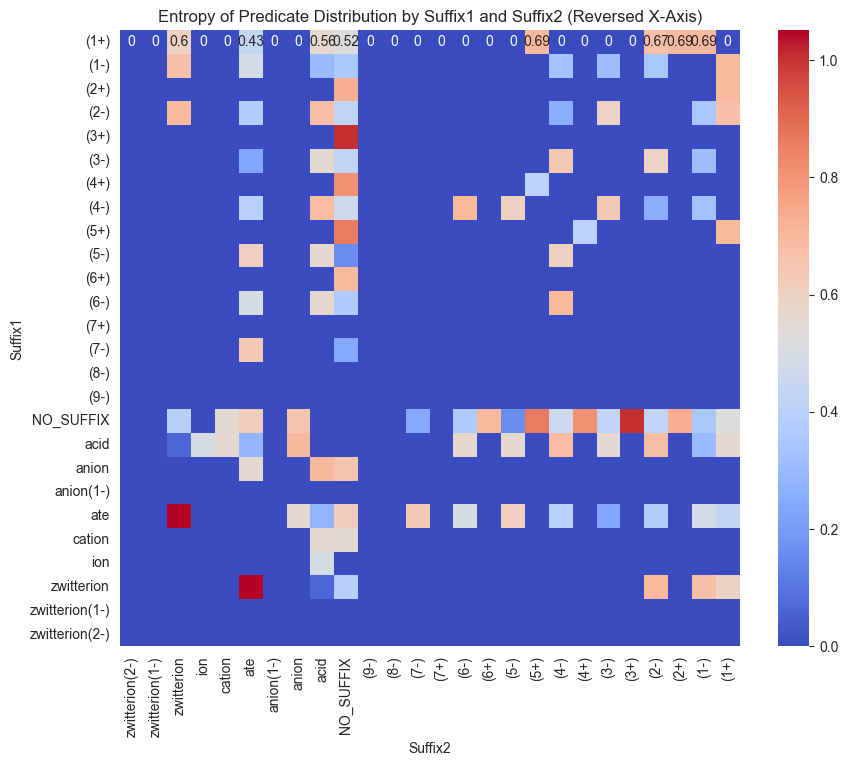

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

data = df

# Display the first few rows of the data to understand its structure
data.head()

# Create a function to calculate entropy for each group
def calculate_entropy(group):
    counts = group.value_counts(normalize=True)
    return entropy(counts)

# Grouping the data by suffix1 and suffix2, then calculating entropy for the predicates
entropy_data = data.groupby(['suffix1', 'suffix2'])['predicate'].apply(calculate_entropy).unstack(fill_value=0)

# Plotting the entropy heatmap with reversed x-axis
plt.figure(figsize=(10, 8))
sns.heatmap(entropy_data.loc[:, ::-1], annot=True, cmap="coolwarm")
plt.title('Entropy of Predicate Distribution by Suffix1 and Suffix2 (Reversed X-Axis)')
plt.xlabel('Suffix2')
plt.ylabel('Suffix1')
plt.show()


In [50]:
pivot_table = df.pivot_table(index=['suffix1', 'suffix2'], columns='predicate', aggfunc='size', fill_value=0).reset_index()
pivot_table.to_csv("tmp/pivot_table.csv", index=False)
pivot_table

predicate,suffix1,suffix2,NO_REL,obo:chebi#is_conjugate_acid_of,obo:chebi#is_conjugate_base_of,obo:chebi#is_tautomer_of
0,(1+),(1-),2,2,0,0
1,(1+),(2+),19,0,19,0
2,(1+),(2-),3,2,0,0
3,(1+),(3+),11,0,0,0
4,(1+),(3-),2,0,0,0
...,...,...,...,...,...,...
271,zwitterion(1-),ate,1,0,0,0
272,zwitterion(1-),zwitterion,0,0,3,0
273,zwitterion(2-),(3-),0,1,0,0
274,zwitterion(2-),acid,1,0,0,0


In [51]:
df[(df["suffix1"] == "(1+)") & (df["suffix2"] == "NO_SUFFIX") & (df["predicate"] == CBO)]

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
3026,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:141055,CHEBI:141057,NaN,NaN,validoxylamine B
10936,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:58644,CHEBI:32818,NaN,NaN,p-coumaroylagmatine
12230,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:64003,CHEBI:64004,NaN,NaN,"N-allyl-6-chloro-1-(3-methylphenyl)-2,3,4,5-te..."
12330,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:64364,CHEBI:10650,NaN,NaN,sumatriptan
13406,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:72567,CHEBI:6438,NaN,NaN,levobunolol
14208,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:75297,CHEBI:31057,NaN,NaN,13-deoxydaunorubicin
14382,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:76278,CHEBI:16299,NaN,NaN,dehydrocoformycin
14672,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:76819,CHEBI:15906,NaN,NaN,demethylmacrocin
14698,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:76922,CHEBI:77055,NaN,NaN,argemonine
16426,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:86083,CHEBI:86085,NaN,NaN,(Z)-p-coumaroylagmatine


In [52]:
df

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
0,acid,anion,obo:chebi#is_conjugate_acid_of,CHEBI:100147,CHEBI:62070,NaN,NaN,nalidix
1,anion,acid,obo:chebi#is_conjugate_base_of,CHEBI:62070,CHEBI:100147,NaN,NaN,nalidix
2,acid,NO_SUFFIX,NO_REL,CHEBI:10046,CHEBI:10045,NaN,NaN,Wyerone
3,NO_SUFFIX,acid,NO_REL,CHEBI:10045,CHEBI:10046,NaN,NaN,Wyerone
4,acid,ate,obo:chebi#is_conjugate_acid_of,CHEBI:10072,CHEBI:71201,NaN,NaN,xanthuren
...,...,...,...,...,...,...,...,...
17161,NO_SUFFIX,(1-),obo:chebi#is_conjugate_acid_of,CHEBI:130073,CHEBI:91301,NaN,NaN,"5,20-diHEPE"
17162,(1-),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:9162,CHEBI:79317,NaN,NaN,sinigrin
17163,NO_SUFFIX,(1-),obo:chebi#is_conjugate_acid_of,CHEBI:79317,CHEBI:9162,NaN,NaN,sinigrin
17164,ate,acid,obo:chebi#is_conjugate_base_of,CHEBI:994,CHEBI:995,NaN,NaN,"cis,cis-2-amino-3-(3-oxoprop-1-enyl)but-2-enedio"


## Create is-a map

In [53]:
is_as = list(chebi.relationships(predicates=[IS_A]))

In [54]:
is_a_map = defaultdict(list)
for s, _, o in is_as:
    is_a_map[s].append(o)

## Fetch Uniprot Synonyms

These are bio-friendly synonyms.

In [55]:
from semsql.sqla.semsql import OwlAxiomAnnotation

q = session.query(OwlAxiomAnnotation)
axiom_anns = list(q)

In [56]:
len(axiom_anns)

716075

In [57]:
up_axiom_anns = [row for row in axiom_anns if row.annotation_predicate == "oio:hasDbXref" and row.annotation_value == "UniProt"]

In [58]:
bio_syn_map = {row.subject: row.value for row in axiom_anns if row.annotation_predicate == "oio:hasDbXref" and row.annotation_value == "UniProt"}
len(bio_syn_map)

16393

In [59]:
len(bio_syn_map)

16393

## RHEA pH Mapping

RHEA provides a table that maps CHEBI IDs to their pH 7.3 stable forms. The mapping may be reflexive
print((e.g.a stable form will map to itself))

The mappings may not be complete - in particular only leaf nodes are mapped.

In [60]:
import pystow
ph_mapping_df = pystow.ensure_csv("rhea", url="https://ftp.expasy.org/databases/rhea/tsv/chebi_pH7_3_mapping.tsv")
for col in ["CHEBI", "CHEBI_PH7_3"]:
    ph_mapping_df[col] = "CHEBI:" + ph_mapping_df[col].astype(str)



In [61]:
ph_mapping_df

,CHEBI,CHEBI_PH7_3,ORIGIN
0,CHEBI:3,CHEBI:3,computation
1,CHEBI:7,CHEBI:7,computation
2,CHEBI:8,CHEBI:8,computation
3,CHEBI:19,CHEBI:19,computation
4,CHEBI:20,CHEBI:20,computation
...,...,...,...
119802,CHEBI:691037,CHEBI:691037,computation
119803,CHEBI:691622,CHEBI:691622,computation
119804,CHEBI:741548,CHEBI:132939,computation
119805,CHEBI:744019,CHEBI:744019,computation


In [62]:
ph_mapping = dict(zip(ph_mapping_df['CHEBI'], ph_mapping_df['CHEBI_PH7_3']))

In [63]:
len(ph_mapping)

119807

In [64]:
# we expected leaf and leaf-y nodes to be mapped
assert ph_mapping[CYSTEINATE_1_MINUS] == CYSTEINE_ZWITTERION

In [65]:
assert ph_mapping[CITRIC_ACID] != CITRIC_ACID

In [66]:
# reflexivity
assert ph_mapping[L_CYSTEINE_ZWITTERION] == L_CYSTEINE_ZWITTERION
assert ph_mapping[CYSTEINE_ZWITTERION] == CYSTEINE_ZWITTERION

In [67]:
assert ph_mapping[WATER] == WATER

In [68]:
# groupings are not mapped
assert AMINO_ACID not in ph_mapping

In [69]:
# create a reverse mapping

rev_ph_mapping = defaultdict(list)
for k, v in ph_mapping.items():
    rev_ph_mapping[v].append(k)
    
len(rev_ph_mapping)

111077

In [70]:
assert L_CYSTEINE_ZWITTERION in rev_ph_mapping[L_CYSTEINE_ZWITTERION]
assert CYSTEINATE_1_MINUS in rev_ph_mapping[CYSTEINE_ZWITTERION]



In [71]:
rhea_sccs = []
rhea_singletons = []
for _, clique in rev_ph_mapping.items():
    if len(clique) > 1:
        rhea_sccs.append(set(clique))
    else:
        rhea_singletons.append(clique[0])

len(rhea_sccs), len(rhea_singletons)

(8140, 102937)

## Pick Canonical from Conjugate Cliques

For each clique, pick the canonical term.

In [72]:

arbitrary_canonical_map = {}
def pick_canonical(ids: List[str]) -> str:
    """
    Pick the canonical term from a list of ids.
    
    Priority order:
    
    1. pH mapping
    2. Uniprot synonyms
    3. Charge 0
    
    :param ids: 
    :return: 
    """
    # ensure deterministic order
    ids = sorted(ids)
    for id in ids:
        if id in ph_mapping:
            return ph_mapping[id]
    for id in ids:
        if id in bio_syn_map:
            return id
    for id in ids:
        if id in charges and charges[id] == 0:
            return id
    # prioritize shorter
    ids = sorted(ids, key=lambda x: len(labels.get(x)))
    for id in ids:
        if id not in charges:
            # last resort
            return id
    if len(ids) == 1:
        return ids[0]
    arbitrary_canonical_map[tuple(ids)] = ids[0]
    return ids[0]
    # raise ValueError(f"Could not find canonical for {ids}")

assert pick_canonical([CITRIC_ACID]) == ph_mapping[CITRIC_ACID]
assert pick_canonical([L_CYSTEINE_ZWITTERION]) == L_CYSTEINE_ZWITTERION
assert pick_canonical([CYSTEINE_ZWITTERION, CYSTEINATE_1_MINUS, CYSTEINIUM]) == CYSTEINE_ZWITTERION
assert pick_canonical([AMINO_ACID, AMINO_ACID_ANION]) == AMINO_ACID
assert pick_canonical([ALPHA_AMINO_ACID, ALPHA_AMINO_ACID_ANION, ALPHA_AMINO_ACID_ZWITTERION]) == ALPHA_AMINO_ACID_ZWITTERION
    

In [73]:
pick_canonical([ALPHA_AMINO_ACID, ALPHA_AMINO_ACID_ANION, ALPHA_AMINO_ACID_ZWITTERION])

'CHEBI:78608'

In [74]:
from typing import Set, Tuple


def create_canonical_map(scc_sets: List[Set[str]]) -> Tuple[Dict[str, Set[str]], Dict[str, str]]:
    """
    Create a mapping between canonical and members of the strongly connected components
    :param scc_sets: 
    :return: 
    """
    canonical_to_members = {}
    for scc in scc_sets:
        canonical = pick_canonical(scc)
        canonical_to_members[canonical] = scc
    members_to_canonical = {m: c for c, ms in canonical_to_members.items() for m in ms}
    return (canonical_to_members, members_to_canonical)

canonical_to_members, members_to_canonical = create_canonical_map(sccs)
assert len(canonical_to_members) > 8000
assert members_to_canonical[CYSTEINE_ZWITTERION] == CYSTEINE_ZWITTERION
assert members_to_canonical[CYSTEINATE_1_MINUS] == CYSTEINE_ZWITTERION

In [75]:
# assert CITRIC_ACID in members_to_canonical


In [76]:
##

In [77]:
# assess completeness of the sccs
missing_in_conjugate_sccs = []
for chem in stem_to_chem.keys():
    if chem not in canonical_to_members:
        missing_in_conjugate_sccs.append(chem)
        
len(missing_in_conjugate_sccs)


31415

In [78]:
missing_in_lexical_analysis = []
for chem in canonical_to_members.keys():
    if chem not in chem_to_stem:
        missing_in_lexical_analysis.append(chem)
        
len(missing_in_lexical_analysis)

1927

In [79]:

for _, vmap in stem_to_chem.items():
    for v1 in vmap.values():
        for v2 in vmap.values():
            if v1 > v2:
                rel = (v1, "?", v2)
                if rel not in conjrels:
                    conjrels.append(rel)
                # conj_graph.add_edge(v1, v2))
conj_graph = calculate_conj_graph(conjrels)
full_sccs = list(nx.strongly_connected_components(conj_graph))
len(full_sccs)

9321

This number is the total number of cliques we will use

In [80]:
canonical_to_members, members_to_canonical = create_canonical_map(full_sccs)
assert len(canonical_to_members) > 9000

In [81]:
labels[members_to_canonical[AMINO_ACID]]

'amino acid'

In [82]:
assert members_to_canonical[AMINO_ACID_ANION] == AMINO_ACID

In [83]:
len(members_to_canonical)

19624

## Exclusion List

In [84]:
ions = list(chebi.descendants(ION, [IS_A]))
exclusion_list = [ion for ion in ions if ion not in canonical_to_members]

In [85]:
len(exclusion_list)

6762

In [86]:
# assert AAAC in exclusion_list, f"expected {AAAC} in exclusion_list"
assert CITRIC_ACID not in exclusion_list
assert AMINO_ACID not in exclusion_list

In [87]:
def rewire(id: str) -> Optional[str]:
    """
    Rewire an ID to its canonical form, if it is not in the exclusion list
    :param id: 
    :return: 
    """
    rewired =  members_to_canonical.get(id, id)
    if rewired in exclusion_list:
        return None
    return rewired

In [88]:
rewire(AAAE)

'CHEBI:83410'

In [89]:
assert rewire(AAAE) != AAAE
assert rewire(AAAE) not in exclusion_list

## Generate Ontology

In [90]:
from typing import Tuple
from pydantic import BaseModel



class Term(BaseModel):
    stanza_type: str = "Term"
    id: str
    label: str
    synonyms: Optional[List[str]] = None
    xrefs: Optional[List[str]] = []
    alt_ids: Optional[List[str]] = None
    parents: List[str] = []
    relationships: List[Tuple[str, str]] = []
    inchi: Optional[str] = None
    physiologically_stable_form: Optional[str] = None
    comments: List[str] = []
    
    def as_obo(self) -> str:
        name = self.label.replace('{', r'\{')
        lines = [
            f"[{self.stanza_type}]",
            f"id: {self.id}",
            f"name: {name}",
        ]
        lines += [f"synonym: {s}" for s in self.synonyms or []]
        lines += [f"alt_id: {alt_id}" for alt_id in self.alt_ids or []]
        lines += [f"is_a: {is_a}" for is_a in self.parents or []]
        lines += [f"xref: {xref}" for xref in self.xrefs or []]
        lines += [f"relationship: {p} {v}" for p, v in self.relationships or []]
        lines += [f"comment: {'; '.join(self.comments)}"] if self.comments else []
        lines += [f"property_value: chemrof:inchi_string \"{self.inchi}\" xsd:string"] if self.inchi else []
        lines += [f"property_value: chemrof:has_physiologically_stable_form {self.physiologically_stable_form}"] if self.physiologically_stable_form else []
        lines += [""]
        return "\n".join(lines)
        
        
class Ontology(BaseModel):
    terms: List[Term] = []
    
    def as_obo(self) -> str:
        lines = [
            f"ontology: chebi-slim",
             "idspace: chemrof https://w3id.org/chemrof/",
            "",
            ]
        return "\n".join(lines + [t.as_obo() for t in self.terms])
        
        


In [91]:
BAD_SUFFIXES = ["zwitterion", "ion", "(1+)", "(2+)"]

def make_term(id: str) -> Optional[Term]:
    """
    Make a term from an ID
    
    :param id: 
    :return: 
    """
    if id in exclusion_list:
        return None
    if members_to_canonical.get(id, id) != id:
        # non-canonical members are not included
        return None
    #if id not in initial_terms:
    #    # filter for testing
    #    return None
    label = labels.get(id, id)
    if id in bio_syn_map:
        label = bio_syn_map[id]
    else:
        for suffix in BAD_SUFFIXES:
            suffix = " " + suffix
            if label.endswith(suffix):
                label = label.replace(suffix, "")
    term = Term(id=id, label=label)
    alt_ids = [x for x in canonical_to_members.get(id, []) if x != id]
    if id in ph_mapping:
        term.physiologically_stable_form = ph_mapping[id]
    if alt_ids:
        term.alt_ids = alt_ids
    else:
        alt_ids = []
    equiv_set = [id] + alt_ids
    comments = []
    for alt_id in equiv_set:
        for parent in is_a_map.get(alt_id, []):
            rewired_parent = rewire(parent)
            if rewired_parent and rewired_parent not in term.parents:
                term.parents.append(rewired_parent)
                if rewired_parent != parent or alt_id != id:
                    comments.append(f"Parent {rewired_parent} was rewired from {alt_id} to {parent}")
        for (p, o) in preserved_rels_by_subject.get(alt_id, []):
            rewired_o = rewire(o)
            if rewired_o and (p, rewired_o) not in term.relationships:
                term.relationships.append((p, rewired_o))
        # TODO: xrefs
        for xref in xrefs.get(alt_id, []):
            if xref.startswith("PMID:"):
                continue
            term.xrefs.append(xref)
        if alt_id in inchis:
            if not term.inchi:
                term.inchi = inchis[alt_id]
    term.comments = comments
    return term


#assert L_CYSTEINE_ZWITTERION in initial_terms
t = make_term(L_CYSTEINE_ZWITTERION)
assert t.label == "L-cysteine"
print(t.as_obo())

[Term]
id: CHEBI:35235
name: L-cysteine
alt_id: CHEBI:32442
alt_id: CHEBI:17561
alt_id: CHEBI:32445
alt_id: CHEBI:32443
is_a: CHEBI:35237
is_a: CHEBI:59869
is_a: CHEBI:26650
is_a: CHEBI:83813
xref: Gmelin:49993
xref: Reaxys:4128886
xref: Gmelin:325857
xref: Beilstein:4128886
xref: YMDB:YMDB00046
xref: Wikipedia:Cysteine
xref: Reaxys:1721408
xref: PDBeChem:CYS
xref: MetaCyc:CYS
xref: KNApSAcK:C00001351
xref: KEGG:D00026
xref: KEGG:C00097
xref: HMDB:HMDB0000574
xref: Gmelin:49991
xref: ECMDB:ECMDB00574
xref: Drug_Central:769
xref: DrugBank:DB00151
xref: CAS:52-90-4
xref: Beilstein:1721408
xref: Gmelin:325860
xref: Reaxys:5921923
xref: Gmelin:325856
xref: Beilstein:5921923
relationship: RO:0018039 CHEBI:35236
relationship: RO:0000087 CHEBI:78675
relationship: RO:0000087 CHEBI:64577
relationship: RO:0000087 CHEBI:77703
relationship: RO:0000087 CHEBI:77746
comment: Parent CHEBI:59869 was rewired from CHEBI:32442 to CHEBI:59814; Parent CHEBI:26650 was rewired from CHEBI:17561 to CHEBI:26650;

In [92]:
assert rewire(is_a_map[CORD_E][0]) not in exclusion_list

In [93]:
t = make_term(CORD_E)
print(t.as_obo())


[Term]
id: CHEBI:213754
name: Cordycepamide E
is_a: CHEBI:83410
comment: Parent CHEBI:83410 was rewired from CHEBI:213754 to CHEBI:46874
property_value: chemrof:inchi_string "InChI=1S/C15H19NO4/c1-9(2)13-14(18)16(3)12(15(19)20-13)8-10-4-6-11(17)7-5-10/h4-7,9,12-13,17H,8H2,1-3H3/t12-,13+/m0/s1" xsd:string
property_value: chemrof:has_physiologically_stable_form CHEBI:213754



In [94]:

# assert CYSTEINE_ZWITTERION in initial_terms
t = make_term(CYSTEINE_ZWITTERION)
assert t.label == "cysteine"
assert "CHEBI:78608" in t.parents
print(t.as_obo())

[Term]
id: CHEBI:35237
name: cysteine
alt_id: CHEBI:32458
alt_id: CHEBI:32456
alt_id: CHEBI:32457
alt_id: CHEBI:15356
is_a: CHEBI:33709
is_a: CHEBI:78608
is_a: CHEBI:26834
is_a: CHEBI:62031
xref: Gmelin:49992
xref: Gmelin:325859
xref: Reaxys:4128885
xref: Gmelin:363235
xref: Beilstein:4128885
xref: Gmelin:49990
xref: Wikipedia:Cysteine
xref: Reaxys:1721406
xref: KNApSAcK:C00007323
xref: KNApSAcK:C00001351
xref: KEGG:C00736
xref: Gmelin:2933
xref: CAS:3374-22-9
xref: Beilstein:1721406
relationship: BFO:0000051 CHEBI:50326
relationship: RO:0000087 CHEBI:78675
comment: Parent CHEBI:33709 was rewired from CHEBI:35237 to CHEBI:35238; Parent CHEBI:78608 was rewired from CHEBI:32458 to CHEBI:33719; Parent CHEBI:26834 was rewired from CHEBI:32456 to CHEBI:63470; Parent CHEBI:62031 was rewired from CHEBI:15356 to CHEBI:26167
property_value: chemrof:inchi_string "InChI=1S/C3H7NO2S/c4-2(1-7)3(5)6/h2,7H,1,4H2,(H,5,6)" xsd:string
property_value: chemrof:has_physiologically_stable_form CHEBI:35237



In [95]:
for is_a in t.parents:
    print(is_a, labels[is_a])

CHEBI:33709 amino acid
CHEBI:78608 alpha-amino acid zwitterion
CHEBI:26834 sulfur-containing amino acid
CHEBI:62031 polar amino acid zwitterion


In [96]:
print(make_term(ALPHA_AMINO_ACID_ZWITTERION).as_obo())

[Term]
id: CHEBI:78608
name: an alpha-amino acid
alt_id: CHEBI:33558
alt_id: CHEBI:33704
alt_id: CHEBI:33719
is_a: CHEBI:33709
xref: MetaCyc:Alpha-Amino-Acids
xref: KEGG:C05167
xref: KEGG:C00045
comment: Parent CHEBI:33709 was rewired from CHEBI:78608 to CHEBI:35238
property_value: chemrof:has_physiologically_stable_form CHEBI:78608



In [97]:
t = make_term("CHEBI:25944")
t.comments
print(t.as_obo())


[Term]
id: CHEBI:25944
name: pesticide
is_a: CHEBI:33232
xref: Wikipedia:Pesticide



In [98]:
GLU_1M = "CHEBI:14321"
assert preserved_rels_by_subject[GLU_1M]
print(make_term(GLU_1M).as_obo())

[Term]
id: CHEBI:14321
name: glutamate
alt_id: CHEBI:18237
alt_id: CHEBI:29987
is_a: CHEBI:78608
is_a: CHEBI:62031
xref: Gmelin:327908
xref: Wikipedia:Glutamic_acid
xref: Reaxys:1723799
xref: KNApSAcK:C00019577
xref: KNApSAcK:C00001358
xref: KEGG:D04341
xref: KEGG:C00302
xref: Gmelin:101971
xref: CAS:617-65-2
xref: Beilstein:1723799
xref: Reaxys:4134100
xref: Gmelin:327903
xref: Beilstein:4134100
relationship: RO:0000087 CHEBI:78675
relationship: BFO:0000051 CHEBI:50329
comment: Parent CHEBI:78608 was rewired from CHEBI:14321 to CHEBI:33558; Parent CHEBI:62031 was rewired from CHEBI:18237 to CHEBI:26167
property_value: chemrof:inchi_string "InChI=1S/C5H9NO4/c6-3(5(9)10)1-2-4(7)8/h3H,1-2,6H2,(H,7,8)(H,9,10)/p-1" xsd:string
property_value: chemrof:has_physiologically_stable_form CHEBI:14321



In [99]:
bio_syn_map[ALPHA_AMINO_ACID_ZWITTERION]

'an alpha-amino acid'

In [100]:
ont = Ontology(terms=[t])
print(ont.as_obo())

ontology: chebi-slim
idspace: chemrof https://w3id.org/chemrof/

[Term]
id: CHEBI:25944
name: pesticide
is_a: CHEBI:33232
xref: Wikipedia:Pesticide



In [101]:
with open("tmp/t.obo", "w") as file:
    file.write(ont.as_obo())

In [102]:
def roots(terms: List[Term]):
    return [t.id for t in terms if not t.parents]

In [103]:

def make_terms_for_ids(ids: List[str]) -> List[Term]:
    """
    Make terms for a list of IDs
    
    :param ids: 
    :return: 
    """
    terms = []
    n = 0
    for id in ids:
        n += 1
        t = make_term(id)
        if t:
            terms.append(t)
        if n % 10000 == 0:
            print(f"Processed {n} IDs, made {len(terms)} terms")
    return terms
        

In [104]:
def write_terms(terms: List[Term], path: str):
    """
    Write terms to a file
    
    :param terms: 
    :param path: 
    :return: 
    """
    ont = Ontology(terms=terms)
    with open(path, "w") as file:
        file.write(ont.as_obo())
        
    

In [105]:
def generate_write_all(ids: List[str], path: str) -> List[Term]:
    """
    Run whole pipeline
    
    :param ids: 
    :param path: 
    :return: 
    """
    terms = make_terms_for_ids(ids)
    write_terms(terms, path)
    return terms

In [106]:
amino_acid_ids = list(chebi.descendants(AMINO_ACID))
assert L_CYSTEINE_ZWITTERION in amino_acid_ids
assert len(amino_acid_ids) > 100

In [107]:
terms = generate_write_all(amino_acid_ids, "tmp/amino_acids.obo")

Processed 10000 IDs, made 7879 terms


In [108]:
[t] = [t for t in terms if t.id == L_CYSTEINE_ZWITTERION]
print(t.as_obo())

[Term]
id: CHEBI:35235
name: L-cysteine
alt_id: CHEBI:32442
alt_id: CHEBI:17561
alt_id: CHEBI:32445
alt_id: CHEBI:32443
is_a: CHEBI:35237
is_a: CHEBI:59869
is_a: CHEBI:26650
is_a: CHEBI:83813
xref: Gmelin:49993
xref: Reaxys:4128886
xref: Gmelin:325857
xref: Beilstein:4128886
xref: YMDB:YMDB00046
xref: Wikipedia:Cysteine
xref: Reaxys:1721408
xref: PDBeChem:CYS
xref: MetaCyc:CYS
xref: KNApSAcK:C00001351
xref: KEGG:D00026
xref: KEGG:C00097
xref: HMDB:HMDB0000574
xref: Gmelin:49991
xref: ECMDB:ECMDB00574
xref: Drug_Central:769
xref: DrugBank:DB00151
xref: CAS:52-90-4
xref: Beilstein:1721408
xref: Gmelin:325860
xref: Reaxys:5921923
xref: Gmelin:325856
xref: Beilstein:5921923
relationship: RO:0018039 CHEBI:35236
relationship: RO:0000087 CHEBI:78675
relationship: RO:0000087 CHEBI:64577
relationship: RO:0000087 CHEBI:77703
relationship: RO:0000087 CHEBI:77746
comment: Parent CHEBI:59869 was rewired from CHEBI:32442 to CHEBI:59814; Parent CHEBI:26650 was rewired from CHEBI:17561 to CHEBI:26650;

In [109]:
from oaklib.datamodels.vocabulary import OWL_CLASS

# all_ids = list(chebi.descendants(ROOT))
all_ids = list(chebi.entities(filter_obsoletes=True, owl_type=OWL_CLASS))
terms = generate_write_all(all_ids, "tmp/all.obo")


Processed 10000 IDs, made 9955 terms
Processed 20000 IDs, made 19917 terms
Processed 30000 IDs, made 29878 terms
Processed 40000 IDs, made 38207 terms
Processed 50000 IDs, made 47129 terms
Processed 60000 IDs, made 56582 terms
Processed 70000 IDs, made 65929 terms
Processed 80000 IDs, made 75147 terms
Processed 90000 IDs, made 84597 terms
Processed 100000 IDs, made 93930 terms
Processed 110000 IDs, made 103890 terms
Processed 120000 IDs, made 113825 terms
Processed 130000 IDs, made 123784 terms
Processed 140000 IDs, made 132470 terms
Processed 150000 IDs, made 141078 terms
Processed 160000 IDs, made 149833 terms
Processed 170000 IDs, made 158566 terms
Processed 180000 IDs, made 166455 terms
Processed 190000 IDs, made 174804 terms
Processed 200000 IDs, made 184378 terms


In [110]:
len(terms)

185206

In [111]:
# many roots expected when we make a subset
len(roots(terms))

16

In [112]:
#write_terms(terms, f"tmp/{ROOT.replace(':', '_')}.obo")

In [113]:
fertirelin = "CHEBI:177856"

In [114]:
t = make_term(fertirelin)
print(t.as_obo())

[Term]
id: CHEBI:177856
name: fertirelin
is_a: CHEBI:25676
xref: KEGG:D07957
xref: Chemspider:163670
xref: CAS:38234-21-8
property_value: chemrof:inchi_string "InChI=1S/C55H76N16O12/c1-4-59-53(82)44-12-8-20-71(44)54(83)38(11-7-19-60-55(56)57)66-49(78)39(21-30(2)3)65-46(75)27-62-47(76)40(22-31-13-15-34(73)16-14-31)67-52(81)43(28-72)70-50(79)41(23-32-25-61-36-10-6-5-9-35(32)36)68-51(80)42(24-33-26-58-29-63-33)69-48(77)37-17-18-45(74)64-37/h5-6,9-10,13-16,25-26,29-30,37-44,61,72-73H,4,7-8,11-12,17-24,27-28H2,1-3H3,(H,58,63)(H,59,82)(H,62,76)(H,64,74)(H,65,75)(H,66,78)(H,67,81)(H,68,80)(H,69,77)(H,70,79)(H4,56,57,60)/t37-,38-,39-,40-,41-,42-,43-,44-/m0/s1" xsd:string



In [115]:
chebi.label(is_a_map[fertirelin][0])

'oligopeptide'